<a href="https://colab.research.google.com/github/rsadaphule/jhu-cv/blob/main/JHU_CV_HW_7_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JHV Computer Vision Homework 7 - Siamese Network

# Step 1: Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split


# Step 2: Load and Preprocess CIFAR-10 Dataset

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


# Step 3: Create Pairs for Siamese Network
This involves creating genuine (same class) and imposter (different class) pairs.

In [3]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.'''
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)



#Step 4: Modify VGGNet-16 for Siamese Network . Here, I'll modify VGGNet-16 by discarding the top layer and adding a custom layer to get the 4096-dimension feature vector.

In [79]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_base_network(input_shape,  l2_penalty=0.001, dropout_rate=0.5):
    '''Base network to be shared (eq. to feature extraction).'''
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)

    #x = Dense(4096, activation='relu')(x) # This is the feature embedding

    x = Dense(4096, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)  # Add dropout

    return Model(base_model.input, x)

input_shape = x_train.shape[1:]
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
outputs = Dense(1, activation='sigmoid')(distance)
siamese_net = Model([input_a, input_b], outputs)


#Step 5: Define Contrastive Loss Function

In [69]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        # Cast y_true to float32 to match y_pred's data type
        y_true = tf.cast(y_true, dtype=tf.float32)

        square_pred = K.square(y_pred)
        genuine_loss = (1 - y_true) * square_pred
        imposter_loss = y_true * K.square(K.maximum(margin - y_pred, 0))
        return K.mean(genuine_loss + imposter_loss)
    return loss


# Step 6 : Create Training and Validation Pairs

In [56]:
import numpy as np

def create_balanced_pairs(images, labels, n_pairs=10000, n_classes=10):
    # Initialize placeholders for pairs and labels
    pairs = []
    pair_labels = []

    # Number of pairs per class (half genuine, half imposter)
    n_pairs_per_class = n_pairs // n_classes
    n_genuine_per_class = n_pairs_per_class // 2
    n_imposter_per_class = n_pairs_per_class - n_genuine_per_class

    for class_id in range(n_classes):
        # Indices for the current class & other classes
        same_class_idx = np.where(labels == class_id)[0]
        diff_class_idx = np.where(labels != class_id)[0]

        # Generate genuine pairs
        for _ in range(n_genuine_per_class):
            idx1, idx2 = np.random.choice(same_class_idx, 2, replace=False)
            pairs.append([images[idx1], images[idx2]])
            pair_labels.append(1)

        # Generate imposter pairs
        for _ in range(n_imposter_per_class):
            idx1 = np.random.choice(same_class_idx)
            idx2 = np.random.choice(diff_class_idx)
            pairs.append([images[idx1], images[idx2]])
            pair_labels.append(0)

    # Convert to numpy arrays
    pairs = np.array(pairs, dtype='float32')
    pair_labels = np.array(pair_labels, dtype='int32')

    # Shuffle pairs and labels in unison
    indices = np.random.permutation(pairs.shape[0])
    pairs, pair_labels = pairs[indices], pair_labels[indices]

    return pairs, pair_labels


In [64]:
import numpy as np
import itertools

# Create training pairs
x_train_pairs, y_train_pairs = create_balanced_pairs(x_train, y_train, n_pairs=10000)

# Similarly, create validation pairs if necessary
x_val_pairs, y_val_pairs = create_balanced_pairs(x_val, y_val, n_pairs=2000)

# Ensure the data structure is correct
x_train_pairs = np.array(x_train_pairs).reshape(-1, 2, 32, 32, 3)
x_val_pairs = np.array(x_val_pairs).reshape(-1, 2, 32, 32, 3)


Step 7 : Compile and Train the Model

In [80]:
siamese_net.compile(optimizer='adam', loss=custom_contrastive_loss(margin=1.0))
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)


early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

history = siamese_net.fit([x_train_pairs[:, 0], x_train_pairs[:, 1]], y_train_pairs,
                          batch_size=128,
                          epochs=10,
                          validation_data=([x_val_pairs[:, 0], x_val_pairs[:, 1]], y_val_pairs),
                          callbacks=[reduce_lr])


Epoch 1/10
79/79 [==============================] - 6s 25ms/step - loss: 0.8665 - val_loss: 0.6556 - lr: 0.0010
Epoch 2/10
79/79 [==============================] - 2s 20ms/step - loss: 0.6010 - val_loss: 0.5623 - lr: 0.0010
Epoch 3/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5436 - val_loss: 0.5291 - lr: 0.0010
Epoch 4/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5211 - val_loss: 0.5147 - lr: 0.0010
Epoch 5/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5109 - val_loss: 0.5078 - lr: 0.0010
Epoch 6/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5059 - val_loss: 0.5043 - lr: 0.0010
Epoch 7/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5033 - val_loss: 0.5024 - lr: 0.0010
Epoch 8/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5019 - val_loss: 0.5014 - lr: 0.0010
Epoch 9/10
79/79 [==============================] - 2s 20ms/step - loss: 0.5011 - val_loss: 0.5008 - lr:

Step 7: Evaluate Model and Plot Learning Curves

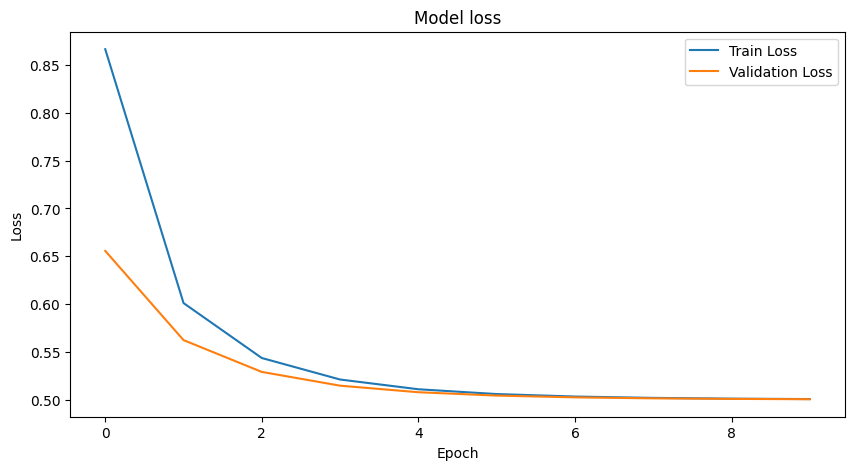

In [81]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Compute similarity score for 2 similar images. The score should closer to 0

In [85]:
from tensorflow.keras.datasets import cifar10

def preprocess_image(image):
    '''Preprocess the image to fit your model.'''
    image = image / 255.0  # Normalize to [0, 1]
    image = np.resize(image, (32, 32, 3))  # Resize to match model input
    return image



# Load the CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# For demonstration, let's use the first two images as img_a and img_b
img_a = x_train[1]
img_b = x_train[1]

# Assume img_a and img_b are two images loaded from your dataset or elsewhere
#img_a = preprocess_image(img_a)
#img_b = preprocess_image(img_b)

# Since our model expects batches of images, we need to add an extra dimension:
img_a = np.expand_dims(img_a, axis=0)
img_b = np.expand_dims(img_b, axis=0)

# Predict
prediction = 0.5 - siamese_net.predict([img_a, img_b])

print(f"Similarity score (closer to 0 means more similar): {prediction[0][0]}")


1/1 [==============================] - 0s 26ms/step
Similarity score (closer to 0 means more similar): -0.0015004873275756836


# Compute similarity score for 2 dissimilar images. The score should closer to 1

In [86]:

# For demonstration, let's use the first two images as img_a and img_b
img_a = x_train[0]
img_b = x_train[1]

# Assume img_a and img_b are two images loaded from your dataset or elsewhere
#img_a = preprocess_image(img_a)
#img_b = preprocess_image(img_b)

# Since our model expects batches of images, we need to add an extra dimension:
img_a = np.expand_dims(img_a, axis=0)
img_b = np.expand_dims(img_b, axis=0)

# Predict
prediction = siamese_net.predict([img_a, img_b])

print(f"Similarity score (closer to 0 means more similar): {prediction[0][0]}")

1/1 [==============================] - 0s 23ms/step
Similarity score (closer to 0 means more similar): 1.0


In [39]:
img_a.shape

(1, 32, 32, 3)

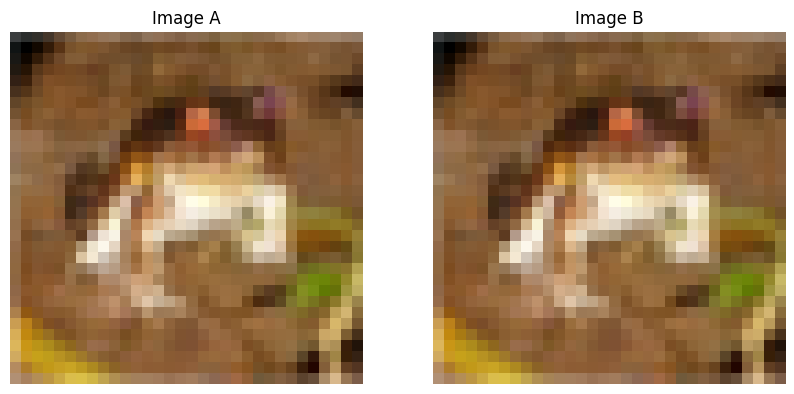

In [87]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to resize image using PIL
def resize_image_with_pil(image, new_size=(128, 128)):
    image = Image.fromarray((image * 255).astype(np.uint8))
    image = image.resize(new_size, Image.NEAREST)
    return np.array(image)

img_a_display = x_train[0] / 255.0
img_b_display = x_train[0] / 255.0

# Assuming img_a and img_b are your original CIFAR-10 images
img_a_resized = resize_image_with_pil(img_a_display)
img_b_resized = resize_image_with_pil(img_b_display)

# Now display the resized images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_a_resized, interpolation='nearest')
axes[0].set_title('Image A')
axes[0].axis('off')

axes[1].imshow(img_b_resized, interpolation='nearest')
axes[1].set_title('Image B')
axes[1].axis('off')

plt.show()
